In [1]:
import torch
from scipy.cluster.hierarchy import num_obs_linkage

n_dim = 2
n_points = 4
n_labels = 1

points = torch.tensor(range(n_points), dtype=torch.int)
labels = torch.rand((n_points, n_labels)) > 0.4


Our example model is very simplistic. The datapoints are just integers from 0 to `n_points` and randomly assigned `labels`. As a first step, we have to embed our datapoints into an `n_dim`-dimensional space. To this end, we implement a simple embedding model that assigns each integer with an `n_dim`-dimensional point. For more complex applications, this embedding model has to be tailored towards the specific input data.

In [2]:
class SimpleEmbedding(torch.nn.Module):
    def __init__(self, n_points, n_dim):
        super(SimpleEmbedding, self).__init__()
        self.out_dim = n_dim
        self.points = torch.rand((n_points, n_dim))*6-3

    def forward(self, idx):
        return self.points[idx]

embedding_model = SimpleEmbedding(n_points, n_dim)
embeddings = embedding_model(points)

For `n_dim == 2`, we can plot the spacial positions of these points:

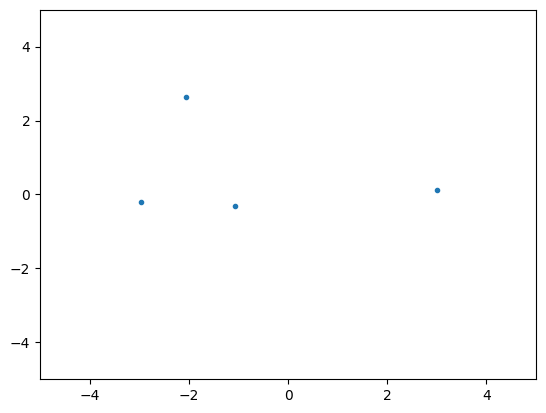

<Figure size 640x480 with 0 Axes>

In [3]:
from potemkin.io.render import draw_2d
draw_2d(embeddings, xlim=(-5, 5), ylim=(-5, 5))

Next, we need to build the town model based on the embedding model. For presentation purposes, a unique color is assigned to each class.

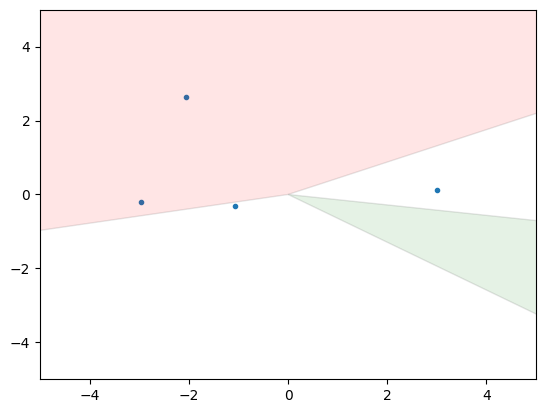

<Figure size 640x480 with 0 Axes>

In [4]:
from potemkin.models.town_model import ConeTownModel
from matplotlib import colormaps
model = ConeTownModel(embedding_model, n_labels, num_houses_per_class=1, num_windows_per_house=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
cmap = colormaps["Set1"]

#colors = list(cmap.colors)[:n_labels]
colors = ['green', 'red']

draw_2d(embeddings, model, town_colors=colors, xlim=(-5, 5), ylim=(-5, 5))

In [5]:
from potemkin.loss.town_loss import DistanceLoss

loss_fn = DistanceLoss()

Passing the datapoints to the model calculates the containment for each frame, window and town, as well as inner and outer distances for frames and windows.

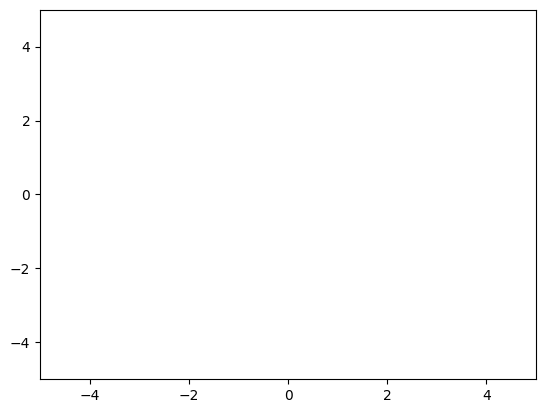

In [6]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from potemkin.io.render import draw_2d_on_axes

fig, ax = plt.subplots()
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
figs = []

for _ in range(100):
    optimizer.zero_grad()
    model_output = model(points)
    loss = loss_fn(model_output, labels)
    accuracy = (model_output['crisp_containment']==labels).float().mean(dim=-1)
    point_colors = torch.stack((1-accuracy, accuracy, 0*accuracy)).T.tolist()

    figs.append(draw_2d_on_axes(embeddings, ax, model, point_colors=point_colors, town_colors=colors))

    loss.backward()
    optimizer.step()

ani = animation.ArtistAnimation(fig, figs, interval=100)
HTML(ani.to_jshtml())